In [1]:
# for use in tutorial and development; do not include this `sys.path` change in production:
import sys ; sys.path.insert(0, "../")

In [2]:
import kglab

namespaces = {
    "acq":  "http://example.org/stuff/",
    "foaf": "http://xmlns.com/foaf/0.1/",
    }

kg = kglab.KnowledgeGraph(
    name = "LINQS simple acquaintance example for PSL",
    base_uri = "http://example.org/stuff/",
    namespaces = namespaces,
    )

kg.load_rdf("../dat/acq.ttl")

Take a look at the `dat/acq.ttl` file to see the people and their relations.
Here's a quick visualization of the graph:

In [3]:
#subgraph = kglab.SubgraphTensor(kg, excludes=excludes)

## Loading a PSL model

Next, we'll use the [`pslpython`](https://pypi.org/project/pslpython/) library implemented in Python (atop Java core software) to define three *predicates* (i.e., relations – similar as in RDF) which are: `Neighbors`, `Likes`, `Knows`

In [4]:
import pslpython.model
import pslpython.partition
import pslpython.predicate
import pslpython.rule

import numpy as np
import pandas as pd
import typing


class PSLModel:
    """
PSL Model
    """

    _PSL_OPTIONS: dict = {
        "log4j.threshold": "INFO"
    }


    def __init__ (
        self,
        *,
        name: str = None,
        ) -> None:
        """
Wrapper for constructing a [`pslpython.model.Model`](https://github.com/linqs/psl/blob/master/psl-python/pslpython/model.py).

    name:
optional name of the PSL model; if not supplied, PSL generates a random name
        """
        self.model = pslpython.model.Model(name)
        self.results: dict = {}


    def add_predicate (
        self,
        raw_name: str,
        closed: bool,
        *,
        size: int = None,
        arg_types = None,
        ) -> "PSLModel":
        """
Add a [`pslpython.predicate.Predicate`](https://github.com/linqs/psl/blob/master/psl-python/pslpython/predicate.py) to this model.
Enough details must be supplied for PSL to infer the number and types of each predicate's arguments.

    raw_name:
name of the predicate; must be unique among all of the predicates

    closed:
indicates that this predicate is fully observed, i.e., all substitutions of this predicate have known values and will behave as evidence for inference; otherwise, if `False` then infer some values of this predicate

    size:
optional, the number of arguments for this predicate

    arg_types:
optional, a list of types for the arguments for this predicate; all arguments will default to string
            
    returns:
this PSL model – use for method chaining
        """
        predicate = pslpython.predicate.Predicate(
            raw_name,
            closed=closed,
            size=size,
            arg_types=arg_types,
            )
        
        self.model.add_predicate(predicate)
        return self


    def add_rule (
        self,
        rule_string: str,
        *,
        weighted: bool = None,
        weight: float = None,
        squared: bool = None,
        ) -> "PSLModel":
        """
Add a [`pslpython.rule.Rule`](https://github.com/linqs/psl/blob/master/psl-python/pslpython/rule.py) to this model.

  * a weighted rule can change its weight or squared status
  * a weighted rule cannot convert into an unweighted rule nor visa-versa
  * unweighted rules are constraints

For more details, see <https://psl.linqs.org/wiki/master/Rule-Specification.html>

    rule_string:
text representation for specifying the rule

    weighted:
indicates that this rule is weighted

    weight:
weight of this rule

    squared:
indicates that this rule's potential is squared

    returns:
this PSL model – use for method chaining
        """
        rule = pslpython.rule.Rule(
            rule_string=rule_string,
            weighted=weighted,
            weight=weight,
            squared=squared,
        )

        self.model.add_rule(rule)
        return self


    def clear_model (
        self
        ) -> "PSLModel":
        """
Clear any pre-existing data from each of the predicates, to initialize the model.

    returns:
this PSL model – use for method chaining
        """
        for predicate in self.model.get_predicates().values():
            predicate.clear_data()

        return self


    def add_data_row (
        self,
        predicate_name: str,
        partition: pslpython.partition.Partition,
        args: list,
        truth_value: float = 1.0,
        ) -> "PSLModel":
        """
Add a single record to a specified predicate.

    predicate_name:
name of the specific predicate; name normalization will be handled internally; raises `ModelError` if the predicate name is not found

    partition:
enum for the partition into which the `data` gets added

    args:
arguments for the record being added, as a list

    truth_value:
truth value of the record being added

    returns:
this PSL model – use for method chaining
        """
        try:
            predicate = self.model.get_predicate(predicate_name)
            assert predicate
        except:
            error = "Unknown predicate: {}".format(predicate_name)
            raise pslpython.model.ModelError(error)

        predicate.add_data_row(
            partition,
            args=args,
            truth_value=truth_value,
        )

        return self


    def infer (
        self,
        *,
        method: str = "",
        cli_options: list = None,
        psl_config: dict = None,
        jvm_options: list = None,
        ) -> None:
        """
Run inference on this model, storing the inferred results in an internal dataframe.

    method:
the inference method to use

    cli_options:
additional options to pass to PSL, based on its CLI options; see <https://psl.linqs.org/wiki/master/Configuration.html>

    psl_config:
configuration options passed directly to the PSL core code; see <https://psl.linqs.org/wiki/master/Configuration-Options.html>

    jvm_options:
options passed to the JVM running the PSL Java library; most commonly `"-Xmx"` and `"-Xms"`
        """
        if not cli_options:
            cli_options = []

        if not psl_config:
            psl_config = self._PSL_OPTIONS

        if not jvm_options:
            jvm_options = []

        self.results = self.model.infer(
            method=method,
            additional_cli_optons=cli_options,
            psl_config=psl_config,
            jvm_options=jvm_options,
        )


    def get_results (
        self,
        predicate_name: str,
        ) -> pd.DataFrame:
        """
Accessor for the inferred results for a specified predicate.

    predicate_name:
name of the specific predicate; name normalization will be handled internally; raises `ModelError` if the predicate name is not found

    returns:
inferred values as a [`pandas.DataFrame`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html), with columns names for each argument plus the `"truth"` value
        """
        try:
            predicate = self.model.get_predicate(predicate_name)
            assert predicate
        except:
            error = "Unknown predicate: {}".format(predicate_name)
            raise pslpython.model.ModelError(error)

        return self.results[predicate]

In [5]:
psl = PSLModel(
    name = "simple acquaintances",
    )

Then add each of the predicates:

In [6]:
psl.add_predicate("Neighbors", closed=True, size=2)
psl.add_predicate("Likes", closed=True, size=2)
psl.add_predicate("Knows", closed=False, size=2)

Next, we'll add a set of probabilistic [*rules*](https://psl.linqs.org/wiki/2.2.1/Rule-Specification.html), all with different weights applied:

  1. "Two people who live in the same place are **more** likely to know each other"
  2. "Two people who don't live in the same place are **less** likely to know each other"
  3. "Two people who share a common interest are **more** likely to know each other"
  4. "Two people who both know a third person are **more** likely to know each other"
  5. "Otherwise, any pair of people are **less** likely to know each other"

In [7]:
psl.add_rule("20: Neighbors(P1, L) & Neighbors(P2, L) & (P1 != P2) -> Knows(P1, P2) ^2")

psl.add_rule("5: Neighbors(P1, L1) & Neighbors(P2, L2) & (P1 != P2) & (L1 != L2) -> !Knows(P1, P2) ^2")

psl.add_rule("10: Likes(P1, L) & Likes(P2, L) & (P1 != P2) -> Knows(P1, P2) ^2")

psl.add_rule("5: Knows(P1, P2) & Knows(P2, P3) & (P1 != P3) -> Knows(P1, P3) ^2")

psl.add_rule("5: !Knows(P1, P2) ^2")

Finally we'll add a *commutative* rule such that "If Person 1 knows Person 2, then Person 2 also knows Person 1."

In [8]:
psl.add_rule("Knows(P1, P2) = Knows(P2, P1) .")

To initialize the model, we'll clear any pre-existing data from each of the predicates:

In [9]:
psl.clear_model()

And we'll define a simple helper function, to format a unique URL within our `acq` vocabulary (a simple extension of `foaf`) based on the purely numeric identifiers used within PSL:

In [10]:
def get_person_id (url):
    return url.replace("http://example.org/stuff/person_", "")

Let's query our KG to populate data into the `Neighbors` predicate in the PSL model, based on `foaf:based_near` that represents living near the same locations:

In [11]:
sparql = """
SELECT DISTINCT ?p1 ?p2
  WHERE {
    ?p1 foaf:based_near ?l .
    ?p2 foaf:based_near ?l .
    FILTER( ?p1 != ?p2 )
  }
  """

for row in kg.query(sparql):
    p1 = get_person_id(row.p1)
    p2 = get_person_id(row.p2)

    psl.add_data_row(
        "Neighbors",
        pslpython.partition.Partition.OBSERVATIONS,
        [p1, p2],
    )

Note: these data points are *observations*, i.e., empirical support for the probabilistic model.
    
Then let's query our KG to populate data into the `Likes` predicate in the PSL model, based on shared interests in `foaf:topic_interest` topics:

In [12]:
sparql = """
SELECT DISTINCT ?p1 ?p2
  WHERE {
    ?p1 foaf:topic_interest ?t .
    ?p2 foaf:topic_interest ?t .
    FILTER( ?p1 != ?p2 )
  }
  """

for row in kg.query(sparql):
    p1 = get_person_id(row.p1)
    p2 = get_person_id(row.p2)

    psl.add_data_row(
        "Likes",
        pslpython.partition.Partition.OBSERVATIONS,
        [p1, p2],
    )

Just for kicks, let's take a look at the internal representation of a PSL predicate, which is a `pandas.DataFrame`:

In [13]:
predicate = psl.model.get_predicate("Likes")
predicate.__dict__

{'_types': [<ArgType.UNIQUE_STRING_ID: 'UniqueStringID'>,
  <ArgType.UNIQUE_STRING_ID: 'UniqueStringID'>],
 '_data': {<Partition.OBSERVATIONS: 'observations'>:      0   1    2
  0    3  22  1.0
  1    3   2  1.0
  2    3  13  1.0
  3    3  15  1.0
  4    3  14  1.0
  ..  ..  ..  ...
  567  2   8  1.0
  568  0  23  1.0
  569  6  11  1.0
  570  7  16  1.0
  571  7  23  1.0
  
  [572 rows x 3 columns],
  <Partition.TARGETS: 'targets'>: Empty DataFrame
  Columns: [0, 1, 2]
  Index: [],
  <Partition.TRUTH: 'truth'>: Empty DataFrame
  Columns: [0, 1, 2]
  Index: []},
 '_name': 'LIKES',
 '_closed': True}

Now we'll load data from the `dat/psl/knows_targets.txt` CSV file, which is a list of `foaf:knows` relations in our graph that we want to analyze.
Each of these has an assumed value of `1.0` (true) or `0.0` (false).
Our PSL analysis will assign probabilities for each so that we can compare which annotations appear to be suspect and require further review:

In [14]:
import csv
import pandas as pd
import rdflib

targets = []
rows_list = []

with open("../dat/psl/knows_targets.txt", "r") as f:
    reader = csv.reader(f, delimiter="\t")
    
    for i, row in enumerate(reader):
        p1, p2 = row
        targets.append((p1, p2))
    
        p1_url = rdflib.URIRef("http://example.org/stuff/person_" + p1)
        p2_url = rdflib.URIRef("http://example.org/stuff/person_" + p2)
        
        if (p1_url, kg.get_ns("foaf").knows, p2_url) in kg.rdf_graph():
            truth = 1.0
            rows_list.append({ 0: p1, 1: p2, "truth": truth})

            psl.add_data_row(
                "Knows",
                pslpython.partition.Partition.TRUTH,
                [p1, p2],
                truth_value=truth,
            )

            psl.add_data_row(
                "Knows",
                pslpython.partition.Partition.TARGETS,
                [p1, p2],
            )
        elif (p1_url, kg.get_ns("acq").wantsIntro, p2_url) in kg.rdf_graph():
            truth = 0.0
            rows_list.append({ 0: p1, 1: p2, "truth": truth})

            psl.add_data_row(
                "Knows",
                pslpython.partition.Partition.TRUTH,
                [p1, p2],
                truth_value=truth,
            )

            psl.add_data_row(
                "Knows",
                pslpython.partition.Partition.TARGETS,
                [p1, p2],
            )
        else:
            print("UNKNOWN", p1, p2)

df_dat = pd.DataFrame(rows_list)   

These data points are considered to be *ground atoms*, each with a *truth* value set initially.
These are also our *targets* for which nodes in the graph to analyze based on the rules.

Next, we'll add `foaf:knows` observations which are in the graph, although not among our set of targets.
This provides more evidence for the probabilistic inference.
Note that since RDF does not allow for representing probabilities on relations, we're using the `acq:wantsIntro` to represent a `foaf:knows` with a `0.0` probability:

In [15]:
sparql = """
SELECT ?p1 ?p2
  WHERE {
    ?p1 foaf:knows ?p2 .
  }
  ORDER BY ?p1 ?p2
  """

for row in kg.query(sparql):
    p1 = get_person_id(row.p1)
    p2 = get_person_id(row.p2)
    
    if (p1, p2) not in targets:
        psl.add_data_row(
            "Knows",
            pslpython.partition.Partition.OBSERVATIONS,
            [p1, p2],
            truth_value=1.0,
        )
    
sparql = """
SELECT ?p1 ?p2
  WHERE {
    ?p1 acq:wantsIntro ?p2 .
  }
  ORDER BY ?p1 ?p2
  """

for row in kg.query(sparql):
    p1 = get_person_id(row.p1)
    p2 = get_person_id(row.p2)
    
    if (p1, p2) not in targets:
        psl.add_data_row(
            "Knows",
            pslpython.partition.Partition.OBSERVATIONS,
            [p1, p2],
            truth_value=0.0,
        )

Now we're ready to optimize the PSL model – this may take a few minutes to run:

In [16]:
psl.infer()

7723 [pslpython.model PSL] INFO --- 0    [main] INFO  org.linqs.psl.cli.Launcher  - Running PSL CLI Version 2.2.2-5f9a472
8052 [pslpython.model PSL] INFO --- 330  [main] INFO  org.linqs.psl.cli.Launcher  - Loading data
8295 [pslpython.model PSL] INFO --- 573  [main] INFO  org.linqs.psl.cli.Launcher  - Data loading complete
8296 [pslpython.model PSL] INFO --- 573  [main] INFO  org.linqs.psl.cli.Launcher  - Loading model from /var/folders/zz/2ffrqd5j7n52x67qd94h_r_h0000gp/T/psl-python/simple acquaintances/simple acquaintances.psl
8473 [pslpython.model PSL] INFO --- 752  [main] INFO  org.linqs.psl.cli.Launcher  - Model loading complete
8474 [pslpython.model PSL] INFO --- 752  [main] INFO  org.linqs.psl.cli.Launcher  - Starting inference with class: org.linqs.psl.application.inference.MPEInference
8672 [pslpython.model PSL] INFO --- 950  [main] INFO  org.linqs.psl.application.inference.MPEInference  - Grounding out model.
14620 [pslpython.model PSL] INFO --- 6898 [main] INFO  org.linqs.psl

Let's examine the results.
We'll get a `pandas.DataFrame` describing the targets in the `Knows` predicate:

In [17]:
df = psl.get_results("Knows")
df.head()

,0,1,truth
0,7,20,0.003000
1,8,13,0.983531
2,8,12,0.980397
3,8,10,0.986561
4,8,21,0.977005


Now we can compare the "truth" values from our targets, with their probabilities from the inference provided by the PSL model:

In [18]:
dat_val = {}

for index, row in df_dat.iterrows():
    p1 = row[0]
    p2 = row[1]
    key = (int(p1), int(p2))
    dat_val[key] = row["truth"]

for index, row in df.iterrows():
    p1 = row[0]
    p2 = row[1]
    key = (int(p1), int(p2))
    df.at[index, "diff"] = row["truth"] - dat_val[key]

pd.set_option("max_rows", None)
df

,0,1,truth,diff
0,7,20,0.003000,0.003000
1,8,13,0.983531,-0.016469
2,8,12,0.980397,-0.019603
3,8,10,0.986561,-0.013439
4,8,21,0.977005,-0.022995
5,9,19,0.209276,0.209276
6,9,17,0.977250,-0.022750
7,1,11,0.003838,0.003838
8,0,22,0.001782,0.001782
9,21,12,0.215542,-0.784458


In other words, which of these "knows" relations in the graph appears to be suspect, based on our rules plus the other evidence in the graph?

Let's visualize a histogram of how the inferred probabilities are distributed:

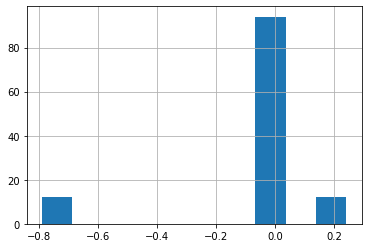

In [19]:
df["diff"].hist();

In most cases there is little or no difference (`0.0 <= d <= 0.2`) in the probabilities for the target relations.
However, some appear to be off by a substantial (`-0.8`) amount, which indicates problems in that part of  our graph data.

The following rows show where these `foaf:knows` annotations in the graph differs significantly from their truth values predicted by PSL:

In [20]:
df[df["diff"] < -0.2]

,0,1,truth,diff
9,21,12,0.215542,-0.784458
16,21,22,0.209063,-0.790937
20,22,21,0.209194,-0.790806
28,5,22,0.232081,-0.767919
33,6,12,0.243229,-0.756771
47,12,6,0.242896,-0.757104
82,7,5,0.245358,-0.754642
86,9,5,0.256280,-0.743720
94,12,21,0.215405,-0.784595
103,22,5,0.231897,-0.768103


Speaking of [*human-in-the-loop*](https://derwen.ai/d/human-in-the-loop) practices for AI, using PSL along with a KG seems like a great way to leverage machine learning, so that the people can focus on parts of the graph that have the most uncertainty.
And, therefore, probably provide the best ROI for investing time+cost into curation.

---

## Exercises

**Exercise 1:**

Build a PSL model that tests the "noodle vs. pancake" rules used in an earlier example with our recipe KG.
Which recipes should be annotated differently?

**Exercise 2:**

Try representing one of the other [PSL examples](https://github.com/linqs/psl-examples/) using RDF and `kglab`.